In [19]:
from sklearn.datasets import fetch_openml
import pandas as pd

data = fetch_openml(name='credit-g', version=1, as_frame=True)
df = data.frame

In [20]:
X = df.drop('class', axis=1)
y = df['class'].map({'good':0, 'bad':1})

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [25]:
from sklearn.model_selection import cross_val_score

log_scores = cross_val_score(
    log_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='f1'
)

print("Logistic Regression CV F1:", log_scores.mean())

Logistic Regression CV F1: 0.1701432140299318


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [27]:
rf_scores = cross_val_score(
    rf_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='f1'
)

print("Random Forest CV F1:", rf_scores.mean())

Random Forest CV F1: 0.327830964536987


In [28]:
from sklearn.svm import SVC

svm_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', SVC())
])

In [29]:
svm_scores = cross_val_score(
    svm_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='f1'
)

print("SVM CV F1:", svm_scores.mean())

SVM CV F1: 0.12885143710703267


In [30]:
import pandas as pd

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM'],
    'F1 Score (CV)': [
        log_scores.mean(),
        rf_scores.mean(),
        svm_scores.mean()
    ]
})

results

,Model,F1 Score (CV)
0,Logistic Regression,0.170143
1,Random Forest,0.327831
2,SVM,0.128851


In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5]
}

In [32]:
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best CV Score: 0.3449250674996009


In [34]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[120  20]
 [ 41  19]]
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       140
           1       0.49      0.32      0.38        60

    accuracy                           0.69       200
   macro avg       0.62      0.59      0.59       200
weighted avg       0.67      0.69      0.67       200



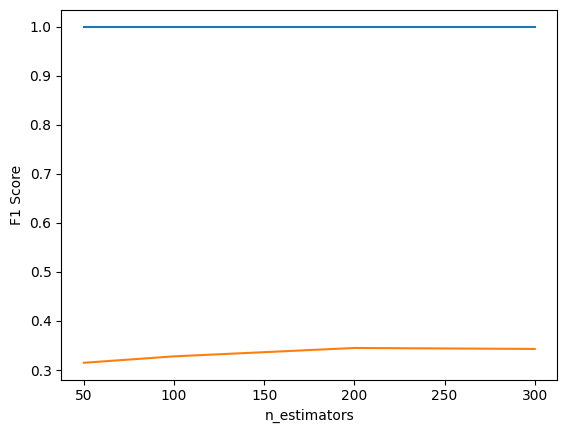

In [35]:
from sklearn.model_selection import validation_curve
import numpy as np
import matplotlib.pyplot as plt

param_range = [50, 100, 200, 300]

train_scores, test_scores = validation_curve(
    rf_pipeline,
    X_train,
    y_train,
    param_name="classifier__n_estimators",
    param_range=param_range,
    cv=5,
    scoring="f1"
)

plt.plot(param_range, np.mean(train_scores, axis=1))
plt.plot(param_range, np.mean(test_scores, axis=1))
plt.xlabel("n_estimators")
plt.ylabel("F1 Score")
plt.show()